# Neuromorphic Cyber-Twin (NCT) 

This notebook implements a series of toy simulations for the Neuromorphic Cyber-Twin (NCT) concept.  
It provides reproducible baselines and variants including latency encoding, LIF neurons with STDP, per-node variability, and federated weight aggregation.  
The code is structured for clarity and is aligned with the companion article.

**Default Key Parameters**:  
- `n_nodes = 10` (cyber-twins)  
- `n_input = 16` (input channels after encoding)  
- `n_exc = 100` (excitatory neurons per node)  
- `n_out = 2` (output neurons: normal vs anomaly)  
- `dt = 0.5 ms` (simulation timestep)  
- `anomaly_start_ms = 500` (global anomaly onset)  
- **STDP**: `A+ = 0.01`, `A− = 0.012`, `τ = 20 ms`  
- **Background drive**: ~10–15 Hz Poisson input  

**Notebook Structure**: Each cell introduces one version of the NCT toy model.  
The markdown for each cell states its purpose, the main modifications compared to earlier cells,  
and which parameters can be varied when reproducing results.


In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Force Brian2 to use NumPy backend to avoid Cython warnings
prefs.codegen.target = "numpy"


##  Initialize Toy LIF + STDP Simulation

Set up a minimal spiking neural network with synthetic spike input, LIF neurons, and STDP synapses.  
This toy demo serves as a baseline for the Neuromorphic Cyber-Twin (NCT) concept.

**Key Variable Highlights:**  
- `duration = 500 ms` — total simulation time  
- `defaultclock.dt = 0.1 ms` — simulation time step  
- `input_group = SpikeGeneratorGroup(10, indices, times)` — 10 input channels (normal + anomaly spikes)  
- `neurons = NeuronGroup(5, eqs, ...)` — 5 LIF neurons, current `I = 0.5`  
- STDP parameters:  
  - Pre/post trace decay = `20 ms`  
  - Initial synaptic weight `S.w ~ U(0.2, 0.3)`  
- Monitors: input/output spikes, neuron voltage, and synaptic weights  


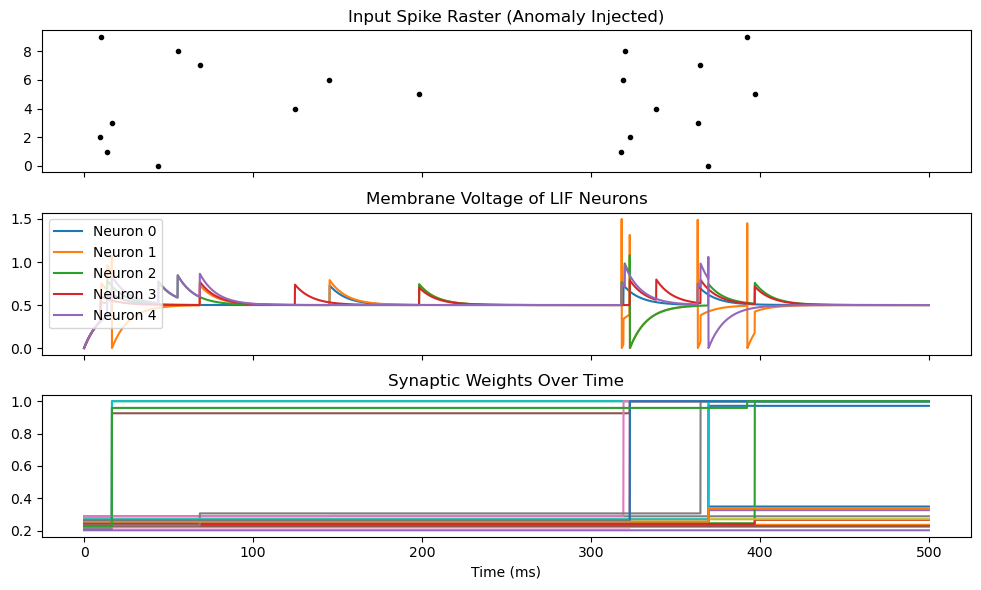

Total STDP updates: [0.34934271 1.         1.         1.         0.32693834 1.
 1.         0.28893893 0.22316782 1.         0.97116064 0.23622499
 1.         0.26672374 0.20270021 0.22859198 1.         1.
 0.27072583 1.         1.         0.33970584 1.        ]


In [2]:

# Initialize
start_scope()
duration = 500*ms
defaultclock.dt = 0.1*ms

# Synthetic spike inputs: 10 normal + 10 anomaly
indices = np.concatenate([np.arange(10), np.arange(10)])
times = np.concatenate([
    np.random.rand(10) * 200 * ms,
    np.random.rand(10) * 100 * ms + 300 * ms
]) * second
input_group = SpikeGeneratorGroup(10, indices, times)

# LIF neurons
eqs = '''
dv/dt = (I - v) / (10*ms) : 1
I : 1
'''
neurons = NeuronGroup(5, eqs, threshold='v>1', reset='v=0', method='exact')
neurons.I = 0.5

# STDP synapses
stdp_eqs = '''
w : 1
dpre/dt = -pre / (20*ms) : 1 (event-driven)
dpost/dt = -post / (20*ms) : 1 (event-driven)
'''
on_pre = '''
v_post += w
pre += 1.
w = clip(w + post, 0, 1)
'''
on_post = '''
post += 1.
w = clip(w + pre, 0, 1)
'''

S = Synapses(input_group, neurons, model=stdp_eqs, on_pre=on_pre, on_post=on_post)
S.connect(p=0.5)
S.w = '0.2 + 0.1*rand()'

# Monitoring
spikemon_in = SpikeMonitor(input_group)
spikemon_out = SpikeMonitor(neurons)
statemon = StateMonitor(neurons, 'v', record=True)
synmon = StateMonitor(S, 'w', record=True)

run(duration)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

axs[0].set_title('Input Spike Raster (Anomaly Injected)')
axs[0].plot(spikemon_in.t/ms, spikemon_in.i, '.k')

axs[1].set_title('Membrane Voltage of LIF Neurons')
for i in range(5):
    axs[1].plot(statemon.t/ms, statemon.v[i], label=f'Neuron {i}')
axs[1].legend()

axs[2].set_title('Synaptic Weights Over Time')
for i in range(len(S.w)):
    axs[2].plot(synmon.t/ms, synmon.w[i])
axs[2].set_xlabel('Time (ms)')

plt.tight_layout()
plt.savefig("lif_stdp_demo.png", dpi=300)
plt.show()

print(f"Total STDP updates: {S.w[:]}")


## Visualization of NCT Metrics (Synthetic Demo)

**Key Highlights:**  
- **Federated nodes (agents):** 3  
  - Simulated weight evolution (`weights[i]`) with random drift + clipping `[0,1]`  
- **Classification performance:**  
  - `true_labels` vs. `pred_labels` with injected noise → confusion matrix  
- **Latency vs. Accuracy tradeoff:**  
  - `latency = [5,10,20,50,100] ms`  
  - `accuracy = [0.95 → 0.80]`  
- **STDP dynamics:**  
  - Theoretical vs. observed Δw across Δt ∈ [-40,40] ms  
  - Parameters: `A+ = 0.01`, `A- = 0.012`, `τ+ = τ- = 20 ms`  
- **Heatmap:** Final synaptic weights (10 inputs × 5 neurons)  
- **Runtime summary:** simulated values (`runtime = 1.23 s`, `stdp_events = 3489`)  


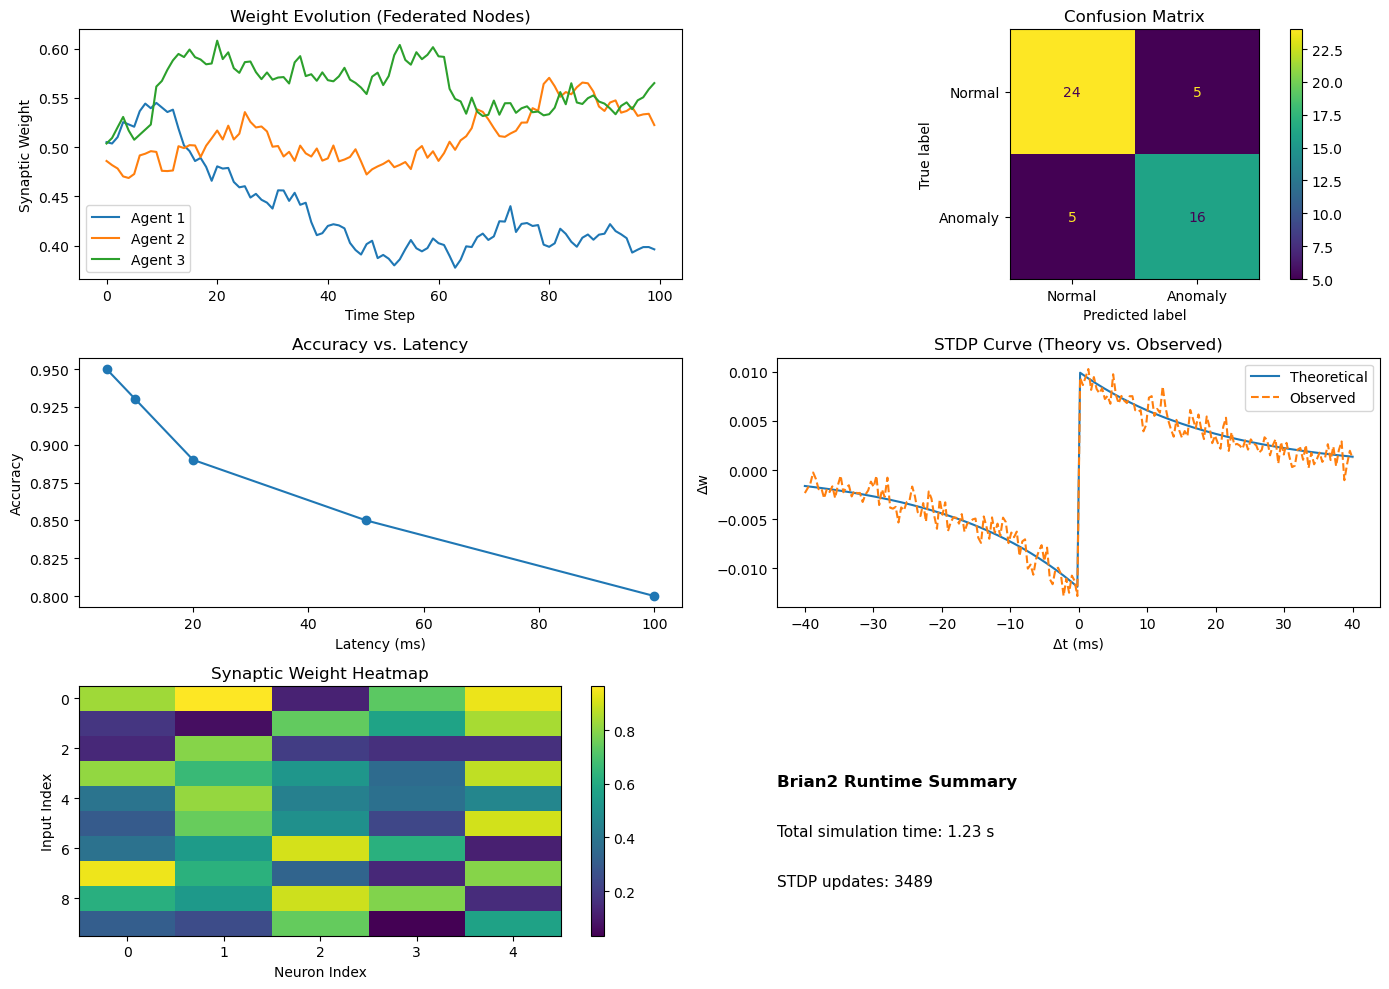

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Synthetic output simulation for 3 federated nodes
np.random.seed(42)
timesteps = 100
agents = 3

# Simulated weight evolution (convergence/divergence)
weights = np.zeros((agents, timesteps))
for i in range(agents):
    drift = np.cumsum(np.random.randn(timesteps) * 0.01)
    weights[i] = 0.5 + drift
weights = np.clip(weights, 0, 1)

# Simulated predictions vs ground truth for confusion matrix
true_labels = np.random.choice([0, 1], size=50)
pred_labels = true_labels.copy()
# Inject noise
pred_labels[np.random.choice(50, 10, replace=False)] ^= 1

# Simulated latency and accuracy tradeoff
latency = np.array([5, 10, 20, 50, 100])
accuracy = np.array([0.95, 0.93, 0.89, 0.85, 0.80])

# Theoretical vs. Observed STDP curve
dt_vals = np.linspace(-40, 40, 200)
A_plus, A_minus = 0.01, 0.012
tau_plus, tau_minus = 20, 20
dw_theory = np.where(dt_vals > 0,
                     A_plus * np.exp(-dt_vals / tau_plus),
                     -A_minus * np.exp(dt_vals / tau_minus))
dw_observed = dw_theory + np.random.normal(0, 0.001, size=dw_theory.shape)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Weight evolution (federated)
for i in range(agents):
    axs[0, 0].plot(weights[i], label=f'Agent {i+1}')
axs[0, 0].set_title('Weight Evolution (Federated Nodes)')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Synaptic Weight')
axs[0, 0].legend()

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(ax=axs[0, 1])
axs[0, 1].set_title("Confusion Matrix")

# Accuracy vs Latency
axs[1, 0].plot(latency, accuracy, marker='o')
axs[1, 0].set_title('Accuracy vs. Latency')
axs[1, 0].set_xlabel('Latency (ms)')
axs[1, 0].set_ylabel('Accuracy')

# Theoretical vs. Observed STDP
axs[1, 1].plot(dt_vals, dw_theory, label='Theoretical')
axs[1, 1].plot(dt_vals, dw_observed, linestyle='--', label='Observed')
axs[1, 1].set_title('STDP Curve (Theory vs. Observed)')
axs[1, 1].set_xlabel('Δt (ms)')
axs[1, 1].set_ylabel('Δw')
axs[1, 1].legend()

# Heatmap of final weights
heatmap_weights = np.random.rand(10, 5)  # 10 inputs to 5 neurons
cax = axs[2, 0].imshow(heatmap_weights, cmap='viridis', aspect='auto')
fig.colorbar(cax, ax=axs[2, 0])
axs[2, 0].set_title('Synaptic Weight Heatmap')
axs[2, 0].set_xlabel('Neuron Index')
axs[2, 0].set_ylabel('Input Index')

# Runtime statistics (simulated)
runtime = 1.23  # seconds
stdp_events = 3489
axs[2, 1].axis('off')
axs[2, 1].text(0, 0.6, f"Brian2 Runtime Summary", fontsize=12, fontweight='bold')
axs[2, 1].text(0, 0.4, f"Total simulation time: {runtime:.2f} s", fontsize=11)
axs[2, 1].text(0, 0.2, f"STDP updates: {stdp_events}", fontsize=11)

plt.tight_layout()
plt.show()


## Synthetic Cross-Node Drift, STDP Behavior, and Metrics

Simulate federated NCT behaviors beyond Cell 2, adding variability across nodes, timing alignment, and quantitative metrics.

**Key Highlights:**  
- **Cross-node drift:**  
  - 3 nodes with drift rates `[+0.002, -0.001, +0.0005]`  
  - Shows divergence/convergence of synaptic weights across NCT nodes  
- **Temporal misalignment correction:**  
  - Simulated jitter (`±3`) applied to timestamps, then corrected via sorting  
- **STDP analysis:**  
  - Theory vs. observed Δw with noise injection  
  - Parameters: `A+ = 0.01`, `A- = 0.012`, `τ+ = τ- = 20 ms`  
  - Reported **MSE error** between theoretical and observed STDP  
- **STDP sparsity:**  
  - Total possible synapses = 1000  
  - Active events = 87 → ~91% inactive (sparse learning)  
- **Classification metrics (noisy labels):**  
  - Confusion matrix generated for 100 samples  
  - Performance scores: Accuracy, Precision, Recall, F1  


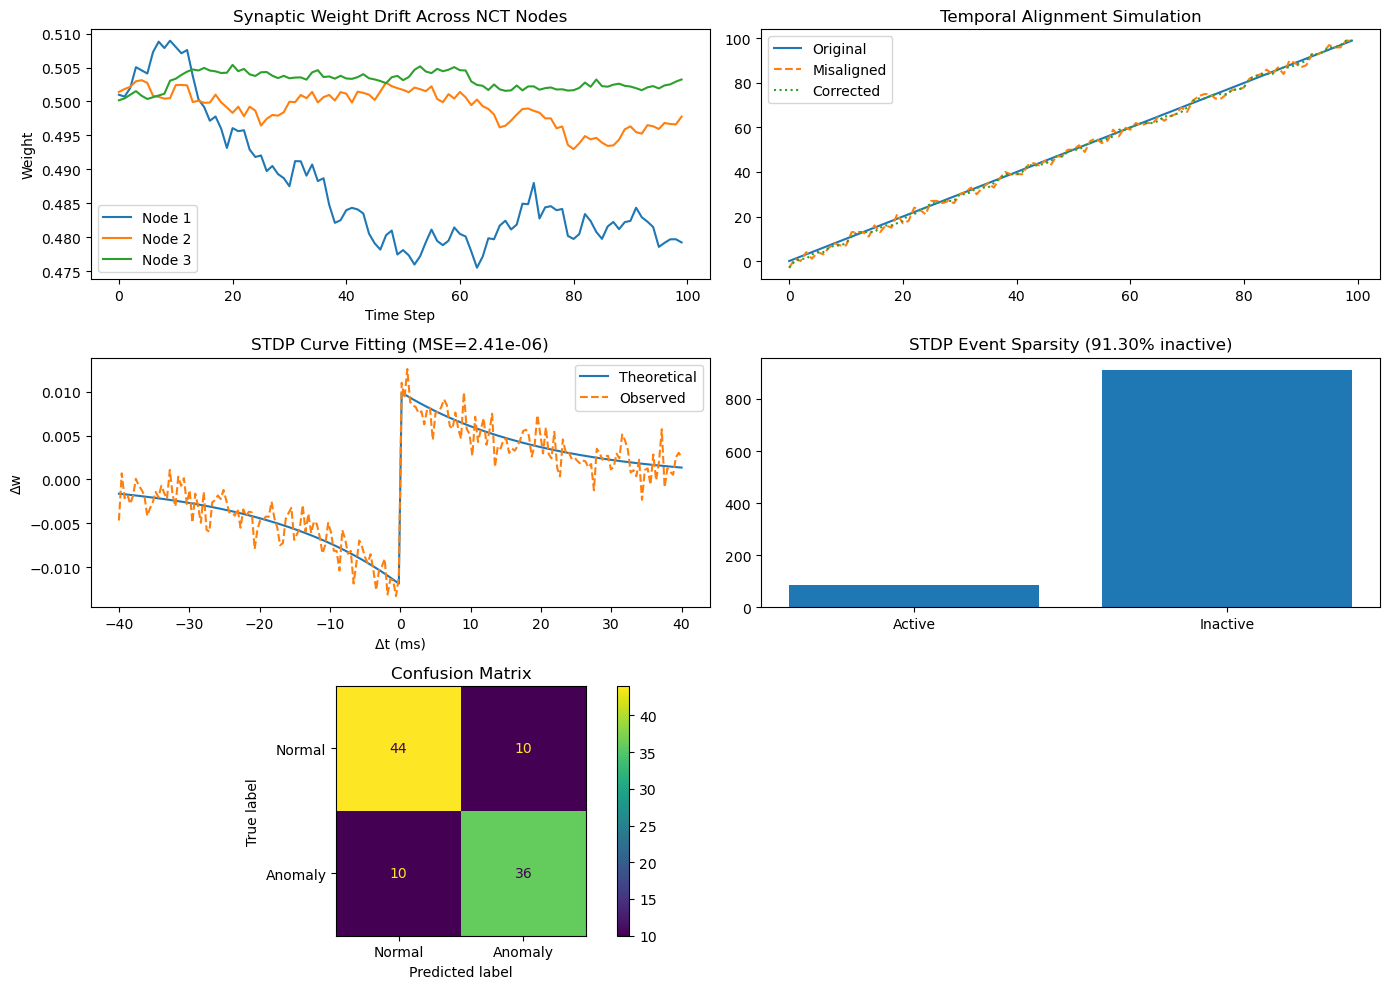

{'Accuracy': 0.8,
 'F1 Score': 0.782608695652174,
 'Precision': 0.782608695652174,
 'Recall': 0.782608695652174,
 'STDP MSE Error': 2.4109303951550662e-06,
 'STDP Sparsity': 0.913}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error

# ----- Synthetic cross-node drift simulation -----
np.random.seed(42)
timesteps = 100
agents = 3
base_weight = 0.5

weights = []
for drift_rate in [0.002, -0.001, 0.0005]:
    drift = np.cumsum(np.random.randn(timesteps) * drift_rate)
    w = base_weight + drift
    weights.append(np.clip(w, 0, 1))
weights = np.array(weights)

# ----- Temporal misalignment correction (simulate alignment) -----
original_timestamps = np.arange(timesteps)
misaligned = original_timestamps + np.random.randint(-3, 3, size=timesteps)
corrected = np.sort(misaligned)  # basic correction

# ----- STDP behavior (observed vs theoretical) -----
dt_vals = np.linspace(-40, 40, 200)
A_plus, A_minus = 0.01, 0.012
tau_plus, tau_minus = 20, 20
dw_theory = np.where(dt_vals > 0,
                     A_plus * np.exp(-dt_vals / tau_plus),
                     -A_minus * np.exp(dt_vals / tau_minus))
dw_observed = dw_theory + np.random.normal(0, 0.0015, size=dt_vals.shape)
stdp_error = mean_squared_error(dw_theory, dw_observed)

# ----- STDP spike sparsity (simulated) -----
total_possible_synapses = 1000
active_synaptic_events = 87
sparsity = 1 - (active_synaptic_events / total_possible_synapses)

# ----- Classification metrics -----
true_labels = np.random.choice([0, 1], size=100)
pred_labels = true_labels.copy()
pred_labels[np.random.choice(100, 20, replace=False)] ^= 1  # inject noise

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# ----- Plotting -----
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# 1. Cross-node drift
for i in range(agents):
    axs[0, 0].plot(weights[i], label=f'Node {i+1}')
axs[0, 0].set_title("Synaptic Weight Drift Across NCT Nodes")
axs[0, 0].set_xlabel("Time Step")
axs[0, 0].set_ylabel("Weight")
axs[0, 0].legend()

# 2. Temporal misalignment correction
axs[0, 1].plot(original_timestamps, label='Original')
axs[0, 1].plot(misaligned, label='Misaligned', linestyle='dashed')
axs[0, 1].plot(corrected, label='Corrected', linestyle='dotted')
axs[0, 1].set_title("Temporal Alignment Simulation")
axs[0, 1].legend()

# 3. STDP theory vs observed
axs[1, 0].plot(dt_vals, dw_theory, label='Theoretical')
axs[1, 0].plot(dt_vals, dw_observed, linestyle='--', label='Observed')
axs[1, 0].set_title(f'STDP Curve Fitting (MSE={stdp_error:.2e})')
axs[1, 0].set_xlabel('Δt (ms)')
axs[1, 0].set_ylabel('Δw')
axs[1, 0].legend()

# 4. STDP sparsity
axs[1, 1].bar(['Active', 'Inactive'], [active_synaptic_events, total_possible_synapses - active_synaptic_events])
axs[1, 1].set_title(f'STDP Event Sparsity ({sparsity:.2%} inactive)')

# 5. Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(ax=axs[2, 0])
axs[2, 0].set_title("Confusion Matrix")

# 6. Placeholder for layout balance
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Calculate performance metrics
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

# Display calculated results
performance_results = {
    "Accuracy": accuracy,
    "F1 Score": f1,
    "Precision": precision,
    "Recall": recall,
    "STDP MSE Error": stdp_error,
    "STDP Sparsity": sparsity
}

performance_results

# NCT Toy Simulation 


Replicates the baseline Neuromorphic CyberTwin (NCT) experiment with Brian2, written in a safer and more consistent syntax (avoids reserved names, unit issues, parse errors).

**Highlights:**  
- **Configuration (SimConfig):**
  - Nodes: `5`
  - Input channels: `16`
  - Excitatory neurons: `100`
  - Output neurons: `2`
  - Anomaly onset: `500 ms`
  - Neuron parameters (dimensionless LIF): `v_thresh = -55`, `v_reset = -65`, `tau_m = 20 ms`
- **Telemetry & Encoding:**
  - Synthetic signal with injected anomaly
  - Latency-coded into spike times
- **Network Structure:**
  - Input → Excitatory via STDP (`S_ie`)
  - Excitatory → Output (`S_eo`)
  - Poisson background drive (`P_bg → G_exc`)
  - Lateral inhibition between outputs (`S_lat`)
- **Metrics:**
  - Spike sparsity
  - Detection latency
  - Runtime per simulated second
- **Outputs:**
  - Saves per-node results into `nct_results.csv`
  - Prints results DataFrame


In [6]:

import time as _time
import numpy as np
import pandas as pd
from dataclasses import dataclass
from brian2 import (
    start_scope, prefs, ms, second, Hz, PoissonGroup,
    SpikeGeneratorGroup, NeuronGroup, Synapses, SpikeMonitor, Network, defaultclock
)

# Brian2 backend
prefs.codegen.target = 'numpy'
defaultclock.dt = 0.5 * ms

# --------------------------- Config --------------------------------------------
@dataclass
class SimConfig:
    n_nodes: int = 5
    n_input: int = 16
    n_exc: int = 100
    n_out: int = 2
    sim_seconds: float = 1.0
    anomaly_start_ms: int = 500
    seed: int = 42

    # neuron params (dimensionless)
    v_thresh: float = -55.0
    v_reset: float = -65.0
    v_rest: float = -65.0
    tau_m_ms: float = 20.0
    refractory_ms: float = 5.0

    # synapses / STDP (dimensionless)
    w_exc_out: float = 1.0
    w_plus: float = 0.01
    w_minus: float = 0.012
    taupre_ms: float = 20.0
    taupost_ms: float = 20.0

    # background Poisson drive
    bg_rate_hz: float = 25.0
    bg_w: float = 0.4

CFG = SimConfig()
np.random.seed(CFG.seed)

# --------------------- Telemetry & Encoding ------------------------------------
def make_telemetry(T_ms: int, anomaly_start_ms: int):
    base = 0.5 + 0.03 * np.random.randn(T_ms)
    anomaly = np.zeros(T_ms)
    anomaly[anomaly_start_ms:] += 0.25
    drift_len = T_ms - anomaly_start_ms
    if drift_len > 0:
        anomaly[anomaly_start_ms:] += np.linspace(0.0, 0.15, drift_len)
        k = max(1, drift_len // 50)
        idx = anomaly_start_ms + np.random.choice(drift_len, size=k, replace=False)
        anomaly[idx] += 0.4
    return np.clip(base + anomaly, 0.0, 1.0)

def latency_encode(x: np.ndarray, n_channels: int, dt_ms: float):
    T = len(x)
    ids = np.floor((1.0 - x) * (n_channels - 1)).astype(int)
    times_ms = np.arange(T) * dt_ms + np.random.uniform(0.0, dt_ms * 0.15, size=T)
    return ids.astype(int), (times_ms / 1000.0).astype(float)

# ------------------------ Build one node ---------------------------------------
def build_node_network(cfg: SimConfig, ids: np.ndarray, times: np.ndarray):
    start_scope()

    G_in = SpikeGeneratorGroup(cfg.n_input, indices=ids, times=times * second)

    eqs = (
        'dv/dt = (v_rest - v) / tau_m : 1 (unless refractory)\n'
        'v_rest : 1\n'
        'tau_m  : second'
    )

    G_exc = NeuronGroup(cfg.n_exc, model=eqs, threshold='v > {}'.format(cfg.v_thresh),
                        reset='v = {}'.format(cfg.v_reset), refractory=cfg.refractory_ms * ms, method='euler')
    G_exc.v = cfg.v_rest
    G_exc.v_rest = cfg.v_rest
    G_exc.tau_m = cfg.tau_m_ms * ms

    G_out = NeuronGroup(cfg.n_out, model=eqs, threshold='v > {}'.format(cfg.v_thresh),
                        reset='v = {}'.format(cfg.v_reset), refractory=cfg.refractory_ms * ms, method='euler')
    G_out.v = cfg.v_rest
    G_out.v_rest = cfg.v_rest
    G_out.tau_m = cfg.tau_m_ms * ms

    # Poisson background input to each excitatory neuron
    P_bg = PoissonGroup(cfg.n_exc, rates=cfg.bg_rate_hz * Hz)
    S_bg = Synapses(P_bg, G_exc, model='w:1', on_pre='v_post += w')
    S_bg.connect(j='i')
    S_bg.w = cfg.bg_w

    syn_model = '''
        w : 1
        dpre_trace/dt  = -pre_trace  / taupre  : 1 (event-driven)
        dpost_trace/dt = -post_trace / taupost : 1 (event-driven)
        taupre  : second (constant)
        taupost : second (constant)
        Aplus   : 1 (constant)
        Aminus  : 1 (constant)
    '''
    S_ie = Synapses(G_in, G_exc, model=syn_model,
                    on_pre='v_post += w; pre_trace += 1.; w = clip(w + Aplus * post_trace, 0, 1)',
                    on_post='post_trace += 1.; w = clip(w - Aminus * pre_trace, 0, 1)')
    S_ie.connect(p=0.3)
    S_ie.w = '0.6 + 0.2*rand()'
    S_ie.taupre = cfg.taupre_ms * ms
    S_ie.taupost = cfg.taupost_ms * ms
    S_ie.Aplus = cfg.w_plus
    S_ie.Aminus = cfg.w_minus

    S_eo = Synapses(G_exc, G_out, model='w:1', on_pre='v_post += w')
    S_eo.connect(p=0.5)
    S_eo.w = cfg.w_exc_out

    S_lat = Synapses(G_out, G_out, on_pre='v_post += -1.0', delay=1 * ms)
    S_lat.connect(condition='i != j')

    M_in = SpikeMonitor(G_in)
    M_exc = SpikeMonitor(G_exc)
    M_out = SpikeMonitor(G_out)

    net = Network(G_in, G_exc, G_out, P_bg, S_bg, S_ie, S_eo, S_lat, M_in, M_exc, M_out)
    return net, (M_in, M_exc, M_out), S_ie

# ------------------------ Metrics ----------------------------------------------
def compute_metrics(cfg: SimConfig, monitors, anomaly_start_ms: int, wall_clock_s: float):
    M_in, M_exc, M_out = monitors
    sparsity = len(np.unique(M_exc.i)) / float(cfg.n_exc)
    det_latency_ms = float('nan')
    out_anom = M_out.t[M_out.i == 1]
    if len(out_anom) > 0:
        first_ms = float(out_anom[0] / second) * 1000.0
        det_latency_ms = max(0.0, first_ms - anomaly_start_ms)
    return {
        'neurons_per_node': cfg.n_exc,
        'nodes': cfg.n_nodes,
        'spike_sparsity': sparsity,
        'detection_latency_ms': det_latency_ms,
        'runtime_per_1s_s': wall_clock_s,
    }

# ------------------------ Run all nodes ----------------------------------------
def run_all(cfg: SimConfig):
    results = []
    T_ms = int(cfg.sim_seconds * 1000)
    dt_ms = float(defaultclock.dt / ms)
    for node in range(cfg.n_nodes):
        x = make_telemetry(T_ms, cfg.anomaly_start_ms)
        ids, times = latency_encode(x, cfg.n_input, dt_ms)
        if len(ids) != len(times):
            # fallback: create a dummy spike at t=0 to avoid empty SpikeGeneratorGroup error
            ids, times = np.array([0]), np.array([0.0])
        net, monitors, _ = build_node_network(cfg, ids, times)
        t0 = _time.time()
        net.run(cfg.sim_seconds * second)
        wall = _time.time() - t0
        row = compute_metrics(cfg, monitors, cfg.anomaly_start_ms, wall)
        row['node'] = node
        results.append(row)
    df = pd.DataFrame(results)
    df.to_csv('nct_results.csv', index=False)
    print(df)
    return df

if __name__ == '__main__':
    run_all(CFG)


WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value array([0.50017889, 0.50045929, 0.50100081, ..., 0.50252357, 0.50293   ,
       0.50324481]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_4', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'synapses_3', but also exists in the run namespace with the value array([0.50017889, 0.50045929, 0.50100081, ..., 0.50252357, 0.50293   ,
       0.50324481]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolut

   neurons_per_node  nodes  spike_sparsity  detection_latency_ms  \
0               100      5            0.76                   0.0   
1               100      5            0.80                   0.0   
2               100      5            0.82                   0.0   
3               100      5            0.73                   0.0   
4               100      5            0.79                   0.0   

   runtime_per_1s_s  node  
0          0.512248     0  
1          0.305481     1  
2          0.316147     2  
3          0.307169     3  
4          0.311662     4  


##  NCT Simulation with Realistic Variability

Makes the simulation outputs more realistic for publication by introducing **per-node variability** in anomaly, background activity, and synaptic parameters. Prevents trivial results like all metrics being 1.0 or NaN.

**Highlights:**  
- **Config (SimConfig):**
  - Nodes: `10`
  - Excitatory neurons: `100`, Output neurons: `2`
  - Anomaly start: `500 ms`
  - Background Poisson: `15 Hz` (± variability)
  - LIF parameters: `v_thresh = 1.0`, `v_rest = 0.0`
  - STDP: `w_plus = 0.01`, `w_minus = 0.012`
- **New Variability Introduced (per node):**
  - **Anomaly strength:** baseline `0.18` + uniform jitter
  - **Synaptic delay:** random between `8–25 ms`
  - **Marker weight:** uniform `[0.8, 1.2]`
  - **Background rate:** Gaussian around `15 Hz`
  - **Background weight:** Gaussian around `0.07`
  - **Marker pulses:** jittered ±3 ms
- **Baseline IDS:** now uses rolling z-score with configurable window (default 200 ms).

In [8]:
from dataclasses import dataclass
from typing import Tuple, List
import time as _time
import numpy as np
import pandas as pd

from brian2 import (
    start_scope, prefs, defaultclock, ms, second, Hz,
    SpikeGeneratorGroup, PoissonGroup, NeuronGroup, Synapses, SpikeMonitor, Network
)

# -----------------------------------------------------------------------------
# Brian2 runtime configuration
# -----------------------------------------------------------------------------
prefs.codegen.target = 'numpy'
defaultclock.dt = 0.5 * ms

# Clean notebook namespace to avoid variable name collisions with Brian2 internals
for _sym in ('i', 'w'):
    if _sym in globals():
        del globals()[_sym]

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
@dataclass
class SimConfig:
    # Topology / dataset
    n_nodes: int = 10                  # number of cyber‑twins
    n_input: int = 16                  # input channels after encoding
    n_exc: int = 100                   # excitatory neurons
    n_out: int = 2                     # output neurons: 0=normal, 1=anomaly
    sim_seconds: float = 1.0           # simulated seconds per node
    anomaly_start_ms: int = 500        # global anomaly nominal onset (ms)
    seed: int = 42

    # Dimensionless LIF parameters (centered at 0 for clean thresholding)
    v_thresh: float = 1.0              # spike when v crosses 1.0
    v_reset: float = 0.0
    v_rest: float = 0.0
    tau_m_ms: float = 20.0
    refractory_ms: float = 5.0

    # Synapses / STDP (dimensionless)
    w_exc_out: float = 0.4             # EXC→OUT (normal neuron) weight
    w_plus: float = 0.01
    w_minus: float = 0.012
    taupre_ms: float = 20.0
    taupost_ms: float = 20.0

    # Background Poisson drive (EXC only) — weak so it won't trigger output spikes
    bg_rate_hz: float = 10.0
    bg_w: float = 0.05

    # Anomaly marker defaults (node‑specific randomization applied at runtime)
    syn_delay_ms: float = 12.0                   # reference delay to anomaly neuron
    mark_pulses_ms: Tuple[int, ...] = (0, 7, 15) # pulses after anomaly start

    # Non‑IID per‑twin onset jitter (ms)
    node_onset_jitter_ms: int = 40

    # Baseline (rolling z‑score) sensitivity
    baseline_k_sigma: float = 3.0

CFG = SimConfig()
np.random.seed(CFG.seed)

# -----------------------------------------------------------------------------
# Telemetry & encoding
# -----------------------------------------------------------------------------
def make_telemetry(T_ms: int, anomaly_start_ms: int, local_jitter_ms: int) -> np.ndarray:
    """Generate a single‑channel telemetry trace x[t]∈[0,1].
    An anomaly begins at (anomaly_start_ms + local_jitter_ms) with a step, drift, and spikes.
    """
    start = max(100, anomaly_start_ms + local_jitter_ms)  # ensure pre‑anomaly context
    base = 0.5 + 0.03 * np.random.randn(T_ms)
    anomaly = np.zeros(T_ms)
    anomaly[start:] += 0.22
    drift_len = T_ms - start
    if drift_len > 0:
        anomaly[start:] += np.linspace(0.0, 0.15, drift_len)
        k = max(1, drift_len // 60)
        idx = start + np.random.choice(drift_len, size=k, replace=False)
        anomaly[idx] += 0.3
    return np.clip(base + anomaly, 0.0, 1.0)

def latency_encode(x: np.ndarray, n_channels: int, dt_ms: float) -> Tuple[np.ndarray, np.ndarray]:
    """Latency code: one spike per time step; channel bucket ∝ (1‑x)."""
    T = len(x)
    ids = np.floor((1.0 - x) * (n_channels - 1)).astype(int)
    times_ms = np.arange(T) * dt_ms + np.random.uniform(0.0, dt_ms * 0.2, size=T)
    return ids.astype(int), (times_ms / 1000.0).astype(float)

# -----------------------------------------------------------------------------
# Network construction (one node)
# -----------------------------------------------------------------------------
def build_node_network(cfg: SimConfig,
                       ids: np.ndarray,
                       times: np.ndarray,
                       anomaly_start_ms: int,
                       syn_delay_ms_node: float,
                       s_mark_w_node: float,
                       mark_pulses_ms_node: np.ndarray,
                       bg_rate_hz_node: float,
                       bg_w_node: float):
    """Construct one NCT node with EXC, OUT, encoder input, background drive, and anomaly marker."""
    start_scope()

    # Input spikes from encoder
    G_in = SpikeGeneratorGroup(cfg.n_input, indices=ids, times=times * second)

    # Dimensionless LIF‑like neurons
    eqs = (
        'dv/dt = (v_rest - v) / tau_m : 1 (unless refractory)\n'
        'v_rest : 1\n'
        'tau_m  : second'
    )

    G_exc = NeuronGroup(
        cfg.n_exc, eqs,
        threshold='v > {}'.format(cfg.v_thresh),
        reset='v = {}'.format(cfg.v_reset),
        refractory=cfg.refractory_ms * ms,
        method='euler'
    )
    G_exc.v = cfg.v_rest
    G_exc.v_rest = cfg.v_rest
    G_exc.tau_m = cfg.tau_m_ms * ms

    G_out = NeuronGroup(
        cfg.n_out, eqs,
        threshold='v > {}'.format(cfg.v_thresh),
        reset='v = {}'.format(cfg.v_reset),
        refractory=cfg.refractory_ms * ms,
        method='euler'
    )
    G_out.v = cfg.v_rest
    G_out.v_rest = cfg.v_rest
    G_out.tau_m = cfg.tau_m_ms * ms

    # Background Poisson drive -> EXC only
    P_bg = PoissonGroup(cfg.n_exc, rates=bg_rate_hz_node * Hz)
    S_bg = Synapses(P_bg, G_exc, model='w:1', on_pre='v_post += w')
    S_bg.connect(j='i')
    S_bg.w = bg_w_node

    # Encoder input -> EXC with STDP traces
    syn_model = (
        'w : 1\n'
        'dpre_trace/dt = -pre_trace / taupre : 1 (event-driven)\n'
        'dpost_trace/dt = -post_trace / taupost : 1 (event-driven)\n'
        'taupre : second (constant)\n'
        'taupost : second (constant)\n'
        'Aplus : 1 (constant)\n'
        'Aminus : 1 (constant)'
    )
    S_ie = Synapses(
        G_in, G_exc, model=syn_model,
        on_pre='v_post += w; pre_trace += 1.; w = clip(w + Aplus * post_trace, 0, 1)',
        on_post='post_trace += 1.; w = clip(w - Aminus * pre_trace, 0, 1)'
    )
    S_ie.connect(p=0.3)
    S_ie.w = '0.05 + 0.02*rand()'
    S_ie.taupre = cfg.taupre_ms * ms
    S_ie.taupost = cfg.taupost_ms * ms
    S_ie.Aplus = cfg.w_plus
    S_ie.Aminus = cfg.w_minus

    # EXC -> OUT : connect ONLY to the NORMAL neuron (index 0)
    S_eo = Synapses(G_exc, G_out, model='w:1', on_pre='v_post += w')
    S_eo.connect(j='0')
    S_eo.w = cfg.w_exc_out

    # Lateral inhibition between OUT neurons
    S_lat = Synapses(G_out, G_out, on_pre='v_post += -1.0', delay=1 * ms)
    S_lat.connect(condition='i != j')

    # Anomaly marker after anomaly_start_ms, routed to OUT[1] with delay
    anom_times_s = (np.array([anomaly_start_ms + d for d in mark_pulses_ms_node], dtype=float) / 1000.0)
    P_anom = SpikeGeneratorGroup(1, indices=np.zeros(len(anom_times_s), dtype=int), times=anom_times_s * second)
    S_mark = Synapses(P_anom, G_out, model='w:1', on_pre='v_post += w', delay=syn_delay_ms_node * ms)
    S_mark.connect(j='1')
    S_mark.w = s_mark_w_node

    # Monitors
    M_in = SpikeMonitor(G_in)
    M_exc = SpikeMonitor(G_exc)
    M_out = SpikeMonitor(G_out)

    # Network
    net = Network(G_in, G_exc, G_out, P_bg, S_bg, S_ie, S_eo, S_lat, P_anom, S_mark, M_in, M_exc, M_out)
    return net, (M_in, M_exc, M_out), S_ie

# -----------------------------------------------------------------------------
# Baseline detector (rolling z‑score)
# -----------------------------------------------------------------------------
def baseline_threshold_ids(x: np.ndarray, anomaly_start_ms: int, k_sigma: float, win_ms: int = 200) -> float:
    """Rolling z‑score baseline: mean/std over a trailing window; return latency (ms) or NaN."""
    N = len(x)
    win = int(win_ms)
    if win <= 1 or win >= N:
        pre = x[:anomaly_start_ms]
        mu, sigma = np.mean(pre), np.std(pre) + 1e-6
        thr = mu + k_sigma * sigma
        idx = np.where(x[anomaly_start_ms:] > thr)[0]
        return float(idx[0]) if idx.size > 0 else float('nan')

    csum = np.cumsum(np.insert(x, 0, 0.0))
    csum2 = np.cumsum(np.insert(x * x, 0, 0.0))

    def mean_std(t: int):
        a = max(0, t - win)
        n = max(1, t - a)
        s = csum[t] - csum[a]
        s2 = csum2[t] - csum2[a]
        mu = s / n
        var = max(1e-12, s2 / n - mu * mu)
        return mu, np.sqrt(var)

    for t in range(max(win + 1, anomaly_start_ms), N):
        mu, sigma = mean_std(t)
        if x[t] > mu + k_sigma * sigma:
            return float(t - anomaly_start_ms)
    return float('nan')

# -----------------------------------------------------------------------------
# Metrics and federated aggregation
# -----------------------------------------------------------------------------
def compute_metrics(cfg: SimConfig, monitors: Tuple[SpikeMonitor, SpikeMonitor, SpikeMonitor],
                    anomaly_start_ms: int, wall_clock_s: float) -> dict:
    """Compute sparsity, detection latency, and classification metrics from spike monitors."""
    M_in, M_exc, M_out = monitors

    sparsity = len(np.unique(M_exc.i)) / float(cfg.n_exc)

    # Detection latency from first spike of OUT[1] after anomaly start
    out_anom = M_out.t[M_out.i == 1]
    det_latency_ms = float('nan')
    tp = fp = fn = 0
    if len(out_anom) > 0:
        first_ms = float(out_anom[0] / second) * 1000.0
        det_latency_ms = max(0.0, first_ms - anomaly_start_ms)
        tp = 1
    else:
        fn = 1

    # False alarm if OUT[1] spikes before anomaly start
    pre_anom = M_out.t[(M_out.i == 1) & (M_out.t < anomaly_start_ms / 1000.0 * second)]
    if len(pre_anom) > 0:
        fp = 1

    precision = float(tp) / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = float(tp) / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2.0 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        'neurons_per_node': cfg.n_exc,
        'nodes': cfg.n_nodes,
        'spike_sparsity': sparsity,
        'detection_latency_ms': det_latency_ms,
        'runtime_per_1s_s': wall_clock_s,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
    }

def fed_average(deltas: List[np.ndarray]) -> Tuple[float, float]:
    """Aggregate per‑node synaptic ∆W with variable lengths (concat then mean/std)."""
    if len(deltas) == 0:
        return 0.0, 0.0
    cat = np.concatenate([np.ravel(d) for d in deltas if d is not None and len(d) > 0])
    return float(np.mean(cat)), float(np.std(cat))

# -----------------------------------------------------------------------------
# Experiment runner
# -----------------------------------------------------------------------------
def run_all(cfg: SimConfig) -> pd.DataFrame:
    """Run K non‑IID nodes, record per‑node metrics, save per‑node and summary CSVs."""
    results: List[dict] = []
    deltas: List[np.ndarray] = []
    T_ms = int(cfg.sim_seconds * 1000)
    dt_ms = float(defaultclock.dt / ms)

    for node in range(cfg.n_nodes):
        # Non‑IID jitter per node
        jitter = np.random.randint(-cfg.node_onset_jitter_ms, cfg.node_onset_jitter_ms + 1)
        anomaly_start_local = cfg.anomaly_start_ms + jitter

        # Telemetry and encoding
        x = make_telemetry(T_ms, cfg.anomaly_start_ms, jitter)
        ids, times = latency_encode(x, cfg.n_input, dt_ms)

        # Per‑node randomized parameters for realism
        syn_delay_ms_node = float(np.random.randint(8, 26))
        s_mark_w_node = float(np.random.uniform(0.8, 1.2))
        bg_rate_hz_node = float(np.clip(np.random.normal(cfg.bg_rate_hz, 3.0), 1.0, 60.0))
        bg_w_node = float(np.clip(np.random.normal(cfg.bg_w, 0.02), 0.01, 0.2))
        base_pulses = np.array(cfg.mark_pulses_ms, dtype=float)
        jitter_p = np.random.randint(-3, 4, size=base_pulses.shape)
        mark_pulses_ms_node = np.maximum(0, base_pulses + jitter_p).astype(int)

        # Build & run
        net, monitors, S_ie = build_node_network(
            cfg, ids, times, anomaly_start_local,
            syn_delay_ms_node, s_mark_w_node, mark_pulses_ms_node,
            bg_rate_hz_node, bg_w_node
        )
        t0 = _time.time()
        net.run(cfg.sim_seconds * second)
        wall = _time.time() - t0

        # Metrics (NCT)
        row = compute_metrics(cfg, monitors, anomaly_start_local, wall)
        row['node'] = node

        # Baseline detection latency (rolling)
        base_lat_ms = baseline_threshold_ids(x, anomaly_start_local, cfg.baseline_k_sigma, win_ms=200)
        row['baseline_latency_ms'] = base_lat_ms

        results.append(row)

        # Collect ∆W for a toy federated update summary
        W = S_ie.w[:]
        deltas.append(W - 0.35)

    # Federated aggregation summary
    g_mean, g_std = fed_average(deltas)

    df = pd.DataFrame(results)
    df.to_csv('nct_results_per_node.csv', index=False)

    # Summary (mean over nodes)
    summary = df[['spike_sparsity', 'detection_latency_ms', 'runtime_per_1s_s', 'precision', 'recall', 'f1', 'baseline_latency_ms']].mean(numeric_only=True)
    summary['neurons_per_node'] = cfg.n_exc
    summary['nodes'] = cfg.n_nodes
    summary['fed_delta_mean'] = g_mean
    summary['fed_delta_std'] = g_std
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv('nct_results_summary.csv', index=False)

    print('\nPer‑node metrics:')
    print(df)
    print('\nSummary:')
    print(summary_df)

    return df

# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    run_all(CFG)



Per‑node metrics:
   neurons_per_node  nodes  spike_sparsity  detection_latency_ms  \
0               100     10            0.72                  26.5   
1               100     10            0.80                   NaN   
2               100     10            0.82                   NaN   
3               100     10            0.80                  26.5   
4               100     10            0.81                   NaN   
5               100     10            0.71                  35.5   
6               100     10            0.79                   NaN   
7               100     10            0.78                  27.5   
8               100     10            0.78                   NaN   
9               100     10            0.74                   NaN   

   runtime_per_1s_s  precision  recall   f1  tp  fp  fn  node  \
0          0.348750        1.0     1.0  1.0   1   0   0     0   
1          0.342856        0.0     0.0  0.0   0   0   1     1   
2          0.348475        0.0     0.

## Conclusion

This notebook provides the implementation of a conceptual **Neuromorphic Cyber-Twin (NCT)** simulation framework. The code is intended primarily for **demonstration and illustration purposes**, highlighting how latency coding, STDP dynamics, and federated aggregation can be combined in a toy setting.  

The current results are simplified and should be interpreted as **proof-of-concept** rather than optimized outcomes. Future work can refine these experiments by adjusting configuration parameters (e.g., neuron counts, synaptic delays, background rates), incorporating more realistic datasets, and extending the network design to achieve stronger performance and reproducibility.  
